In [1]:
import glob
import deimos
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

### UIMF conversion

In [2]:
import uimfpy

In [3]:
%%time
# Load from UIMF
ms1_ = uimfpy.UIMFReader.UIMFReader('091222_pepmix_4ionlevels_noCID.uimf')
ms1_ = ms1_.to_dataframe()

####################################################################################################
# Average TOF length: 99376.0 (0.0)
# M/Z calibrators by params: {('0.57525774', '0.03163628', 1.0): <uimfpy.MzCalibrator.MzCalibrator object at 0x7fce7e5b7400>}
####################################################################################################
CPU times: user 46.1 s, sys: 2.88 s, total: 49 s
Wall time: 49.1 s


In [4]:
%%time
# Load from UIMF
ms2_ = uimfpy.UIMFReader.UIMFReader('091222_pepmix_4ionlevels_withCID_25V.uimf')
ms2_ = ms2_.to_dataframe()

####################################################################################################
# Average TOF length: 99376.0 (0.0)
# M/Z calibrators by params: {('0.57525774', '0.03163628', 1.0): <uimfpy.MzCalibrator.MzCalibrator object at 0x7fce57254670>}
####################################################################################################
CPU times: user 41.9 s, sys: 2.23 s, total: 44.1 s
Wall time: 44.4 s


In [5]:
# Drop first frame
ms1 = ms1_.loc[ms1_['frame'] > 1, :]
ms2 = ms2_.loc[ms2_['frame'] > 1, :]

In [6]:
# Drop unneeded cols
ms1 = ms1[['frame', 'drift_time', 'mz', 'intensity']]
ms2 = ms2[['frame', 'drift_time', 'mz', 'intensity']]

In [7]:
# Sum over frames
ms1 = deimos.collapse(ms1, keep=['mz', 'drift_time'])
ms2 = deimos.collapse(ms2, keep=['mz', 'drift_time'])

In [8]:
# Save
deimos.save('091222_pepmix_4ionlevels.h5', ms1, key='ms1', mode='w')
deimos.save('091222_pepmix_4ionlevels.h5', ms2, key='ms2', mode='a')

### Load from HDF5

In [9]:
# Initialize containers
data = {'ms1': {},
        'ms2': {}
       }

subset = {'ms1': {},
          'ms2': {}
         }

In [10]:
%%time
# Load
data['ms1']['raw'] = deimos.load('091222_pepmix_4ionlevels.h5', key='ms1')
data['ms2']['raw'] = deimos.load('091222_pepmix_4ionlevels.h5', key='ms2')

CPU times: user 996 ms, sys: 367 ms, total: 1.36 s
Wall time: 1.4 s


In [11]:
%%time
# Nominal threshold to improve efficiency
data['ms1']['thresh'] = deimos.threshold(data['ms1']['raw'],
                                         threshold=32)

data['ms2']['thresh'] = deimos.threshold(data['ms2']['raw'],
                                         threshold=32)

CPU times: user 121 ms, sys: 16.8 ms, total: 137 ms
Wall time: 135 ms


In [12]:
%%time
# Select high intensity feature
# Human neurotensin, +2 charge, m/z 837.0
subset['ms1']['raw'] = deimos.slice(data['ms1']['raw'],
                                    by=['drift_time', 'mz'],
                                    low=[970, 836.5],
                                    high=[985, 840])

CPU times: user 174 ms, sys: 21.3 ms, total: 195 ms
Wall time: 192 ms


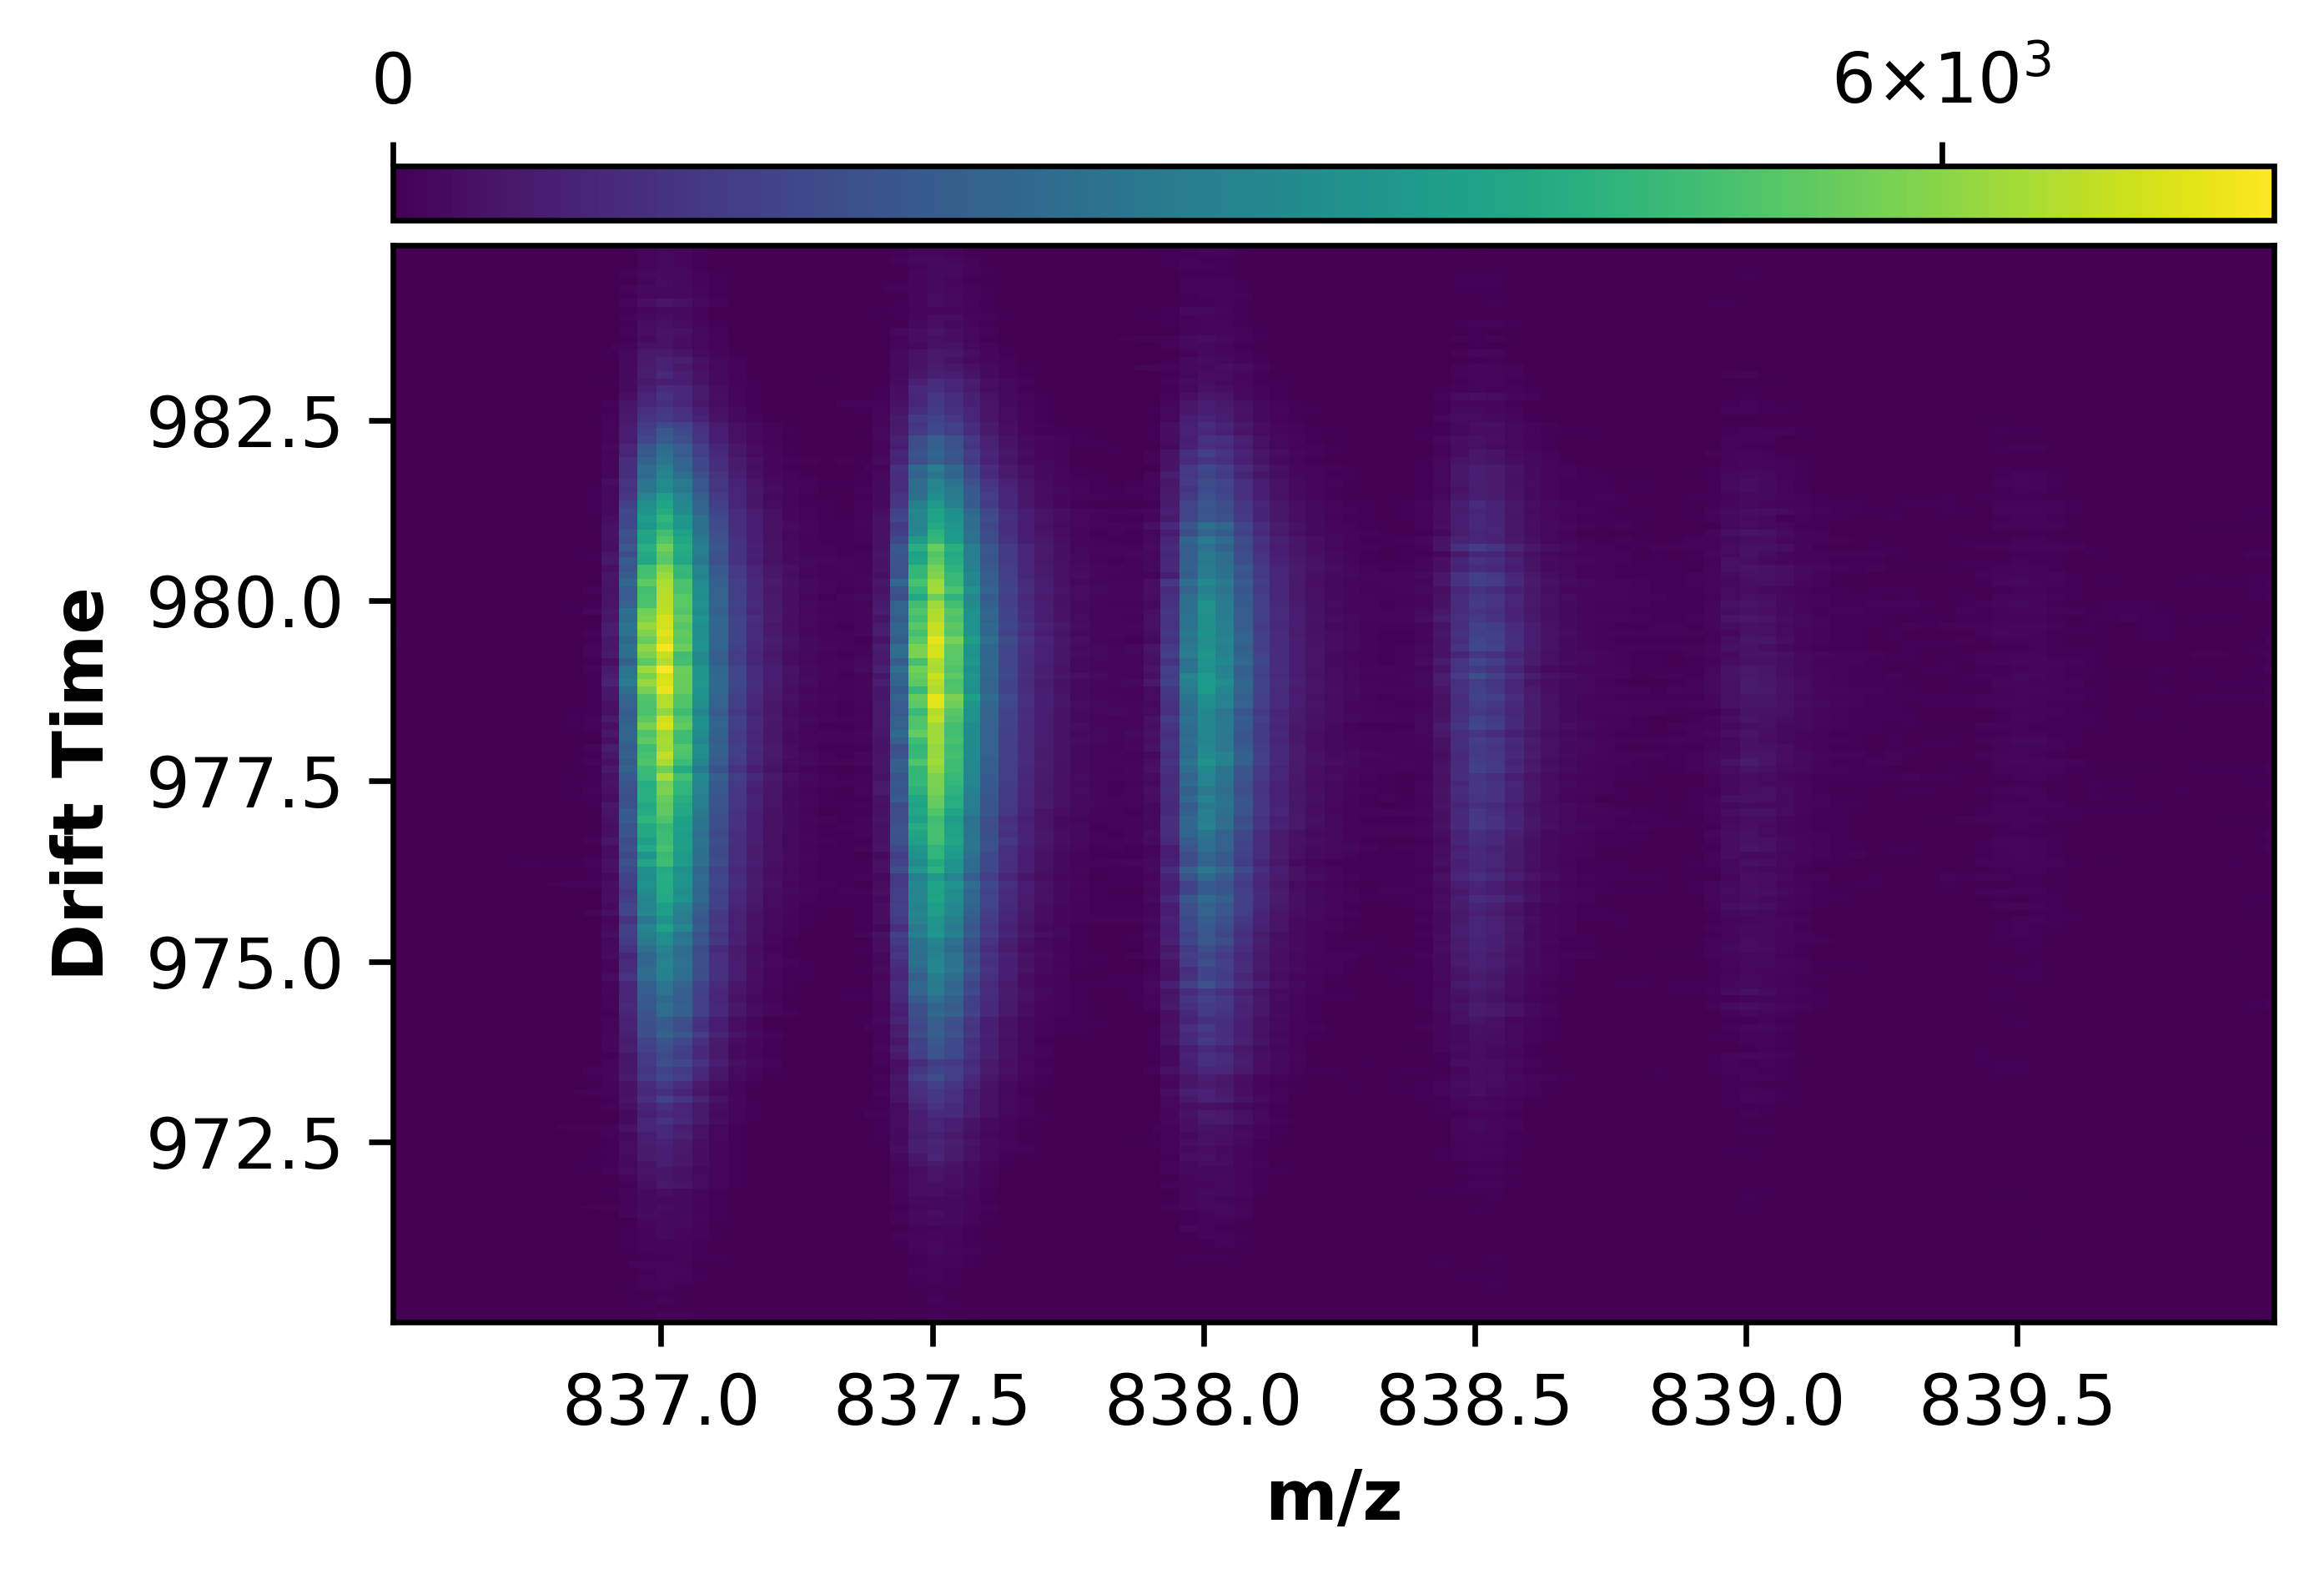

In [13]:
# Plot m/z versus drift
deimos.plot.grid(subset['ms1']['raw'], cmap='viridis')
plt.show()

### Smooth data

In [14]:
%%time
# Smooth in drift time dimension
data['ms1']['smooth'] = deimos.filters.smooth(data['ms1']['thresh'],
                                              dims=['mz', 'drift_time'],
                                              radius=[0, 2],
                                              tol=0.05,
                                              iterations=10)

data['ms2']['smooth'] = deimos.filters.smooth(data['ms2']['thresh'],
                                              dims=['mz', 'drift_time'],
                                              radius=[0, 2],
                                              tol=0.05,
                                              iterations=10)

CPU times: user 7.29 s, sys: 481 ms, total: 7.77 s
Wall time: 7.77 s


In [15]:
%%time
# Select high intensity feature
# Human neurotensin, +2 charge, m/z 837.0
subset['ms1']['smooth'] = deimos.slice(data['ms1']['smooth'],
                                       by=['drift_time', 'mz'],
                                       low=[970, 836.5],
                                       high=[985, 840])

# Select monoisopic peak
subset['ms1']['dt'] = deimos.slice(subset['ms1']['raw'],
                                   by='mz',
                                   low=836, high=837.3)
subset['ms1']['dt-smooth'] = deimos.slice(subset['ms1']['smooth'],
                                          by='mz',
                                          low=836, high=837.3)

# Sum over mz and sort
subset['ms1']['dt']  = deimos.collapse(subset['ms1']['dt'],
                                       keep='drift_time').sort_values(by='drift_time')
subset['ms1']['dt-smooth'] = deimos.collapse(subset['ms1']['dt-smooth'],
                                             keep='drift_time').sort_values(by='drift_time')

CPU times: user 11.2 ms, sys: 4.1 ms, total: 15.3 ms
Wall time: 12.7 ms


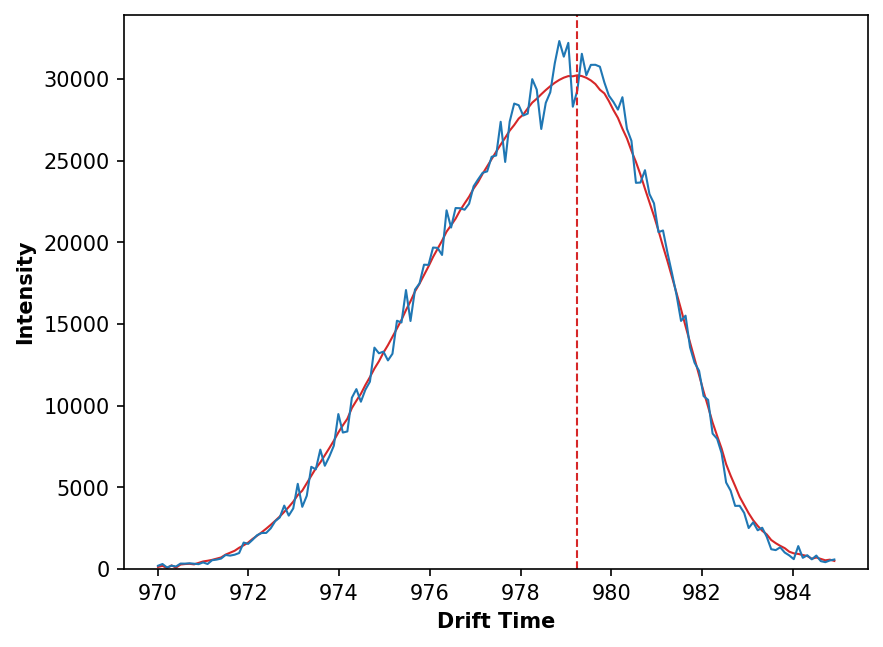

In [16]:
# Plot drift time profile
fig, ax = plt.subplots(1, dpi=150, facecolor='w')

# Smoothed
ax.plot(subset['ms1']['dt-smooth']['drift_time'],
        subset['ms1']['dt-smooth']['intensity'],
        color='C3', linewidth=1)

# Raw (unsmoothed)
ax.plot(subset['ms1']['dt']['drift_time'],
        subset['ms1']['dt']['intensity'],
        color='C0', linewidth=1)

# Apex coordinate
ax.axvline(subset['ms1']['dt-smooth']['drift_time'].values[np.argmax(subset['ms1']['dt-smooth']['intensity'].values)],
           color='C3', linewidth=1, linestyle='--')

# Axis labels
ax.set_xlabel('Drift Time', fontweight='bold')
ax.set_ylabel('Intensity', fontweight='bold')

# Y-axis limits
ax.set_ylim(0, None)

plt.show()

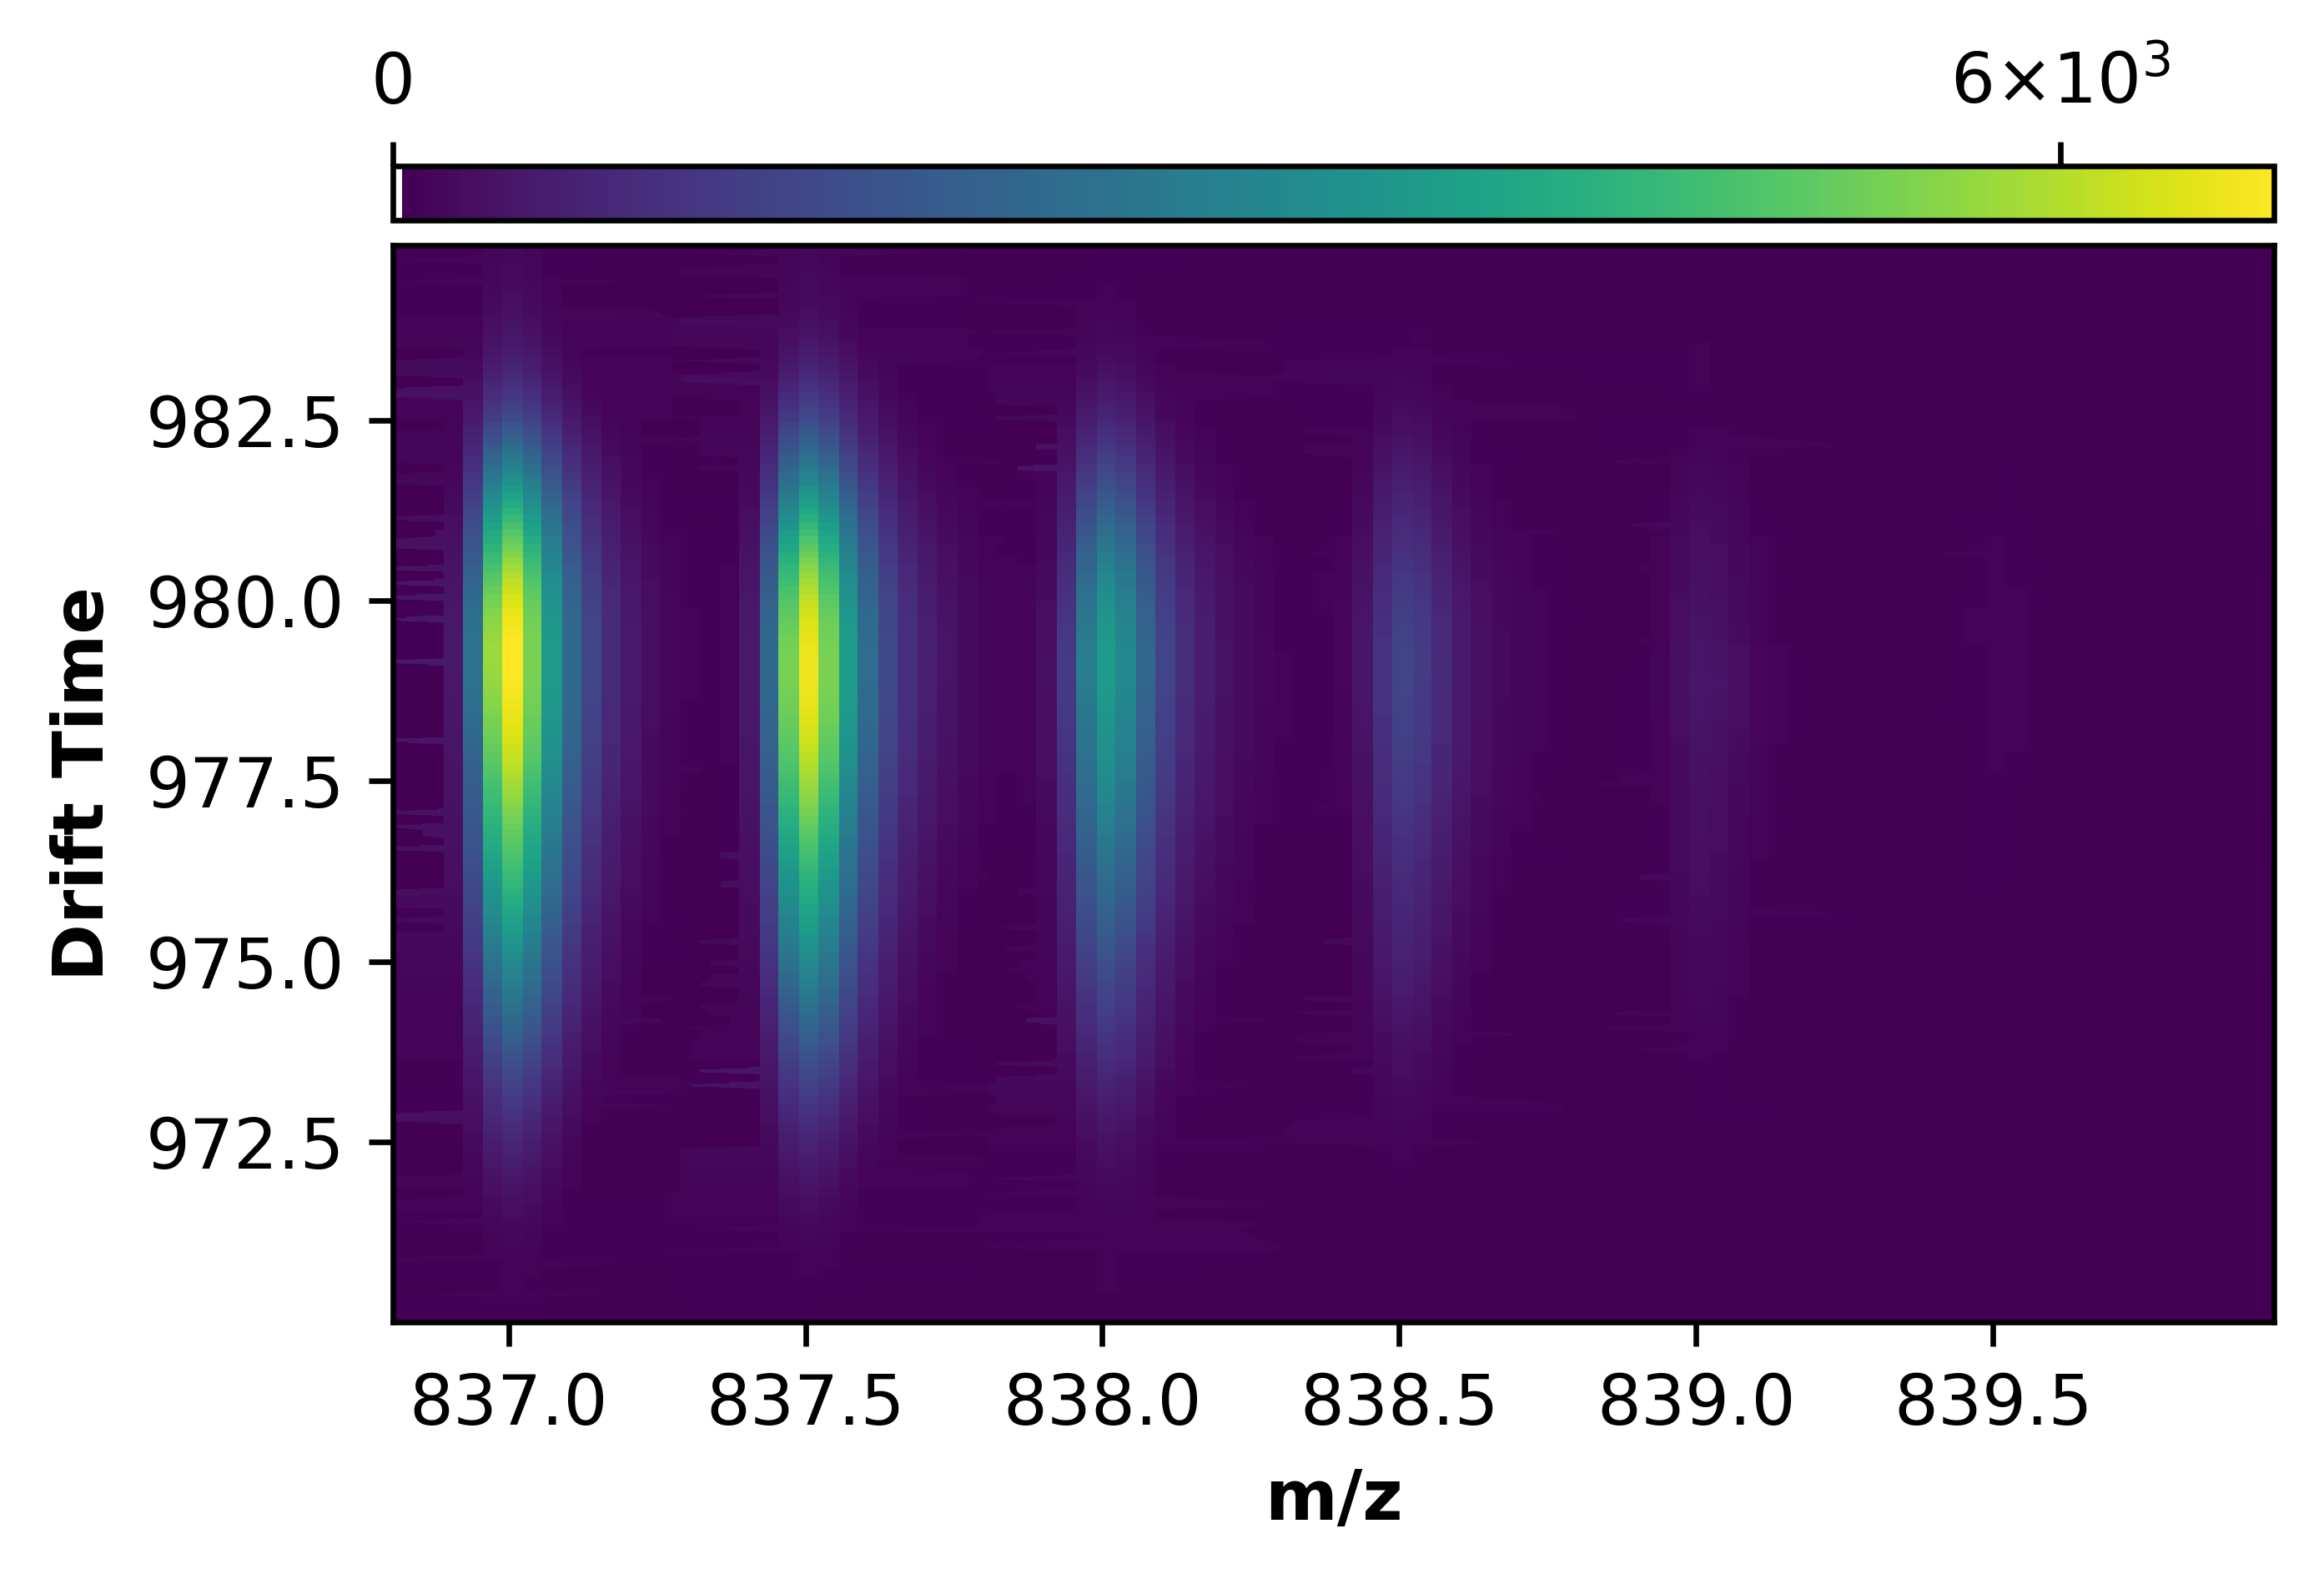

In [17]:
# Plot m/z versus drift, smoothed
deimos.plot.grid(subset['ms1']['smooth'], cmap='viridis')
plt.show()

### Peak detection

In [18]:
%%time
# Perform peak detection
data['ms1']['peaks'] = deimos.peakpick.persistent_homology(data['ms1']['smooth'],
                                                           dims=['mz', 'drift_time'],
                                                           radius=[2, 90])

# Threshold resulting peaks
data['ms1']['peaks'] = deimos.threshold(data['ms1']['peaks'],
                                        threshold=200)

# Sort by intensity, descending
data['ms1']['peaks'].sort_values(by='intensity', ascending=False).head()

CPU times: user 2.65 s, sys: 407 ms, total: 3.06 s
Wall time: 2.87 s


mz  drift_time    intensity  persistence  mz_weighted   
141  837.006897  979.251099  6768.260742       6735.0   837.010742  \
42   837.506287  979.052368  6599.304688       6527.0   837.511108   
138  530.835022  666.713623  4773.026855       4740.0   530.834595   
139  724.932617  856.124207  4206.364258       4173.0   724.946350   
152  643.414856  778.114075  4080.811768       4047.0   643.418396   

     drift_time_weighted  
141           978.296265  
42            978.247375  
138           666.452271  
139           855.884888  
152           778.243530

In [19]:
%%time
# Perform peak detection
data['ms2']['peaks'] = deimos.peakpick.persistent_homology(data['ms2']['smooth'],
                                                           dims=['mz', 'drift_time'],
                                                           radius=[2, 90])

# Threshold resulting peaks
data['ms2']['peaks'] = deimos.threshold(data['ms2']['peaks'],
                                        threshold=50)

# Sort by intensity, descending
data['ms2']['peaks'].sort_values(by='intensity', ascending=False).head()

CPU times: user 1.31 s, sys: 190 ms, total: 1.5 s
Wall time: 1.36 s


mz  drift_time    intensity  persistence  mz_weighted   
5670  836.973633  978.853638  5260.693359       5227.0   836.989136  \
179   837.506287  978.654846  5152.695801       5085.0   837.503784   
99    838.005737  978.853638  2838.266357       2761.0   838.003845   
4126  724.932617  855.627380  1798.345337       1765.0   724.939575   
4114  725.428345  855.428589  1361.970581       1328.0   725.438843   

      drift_time_weighted  
5670           977.849304  
179            977.809998  
99             977.838440  
4126           855.200928  
4114           855.171509

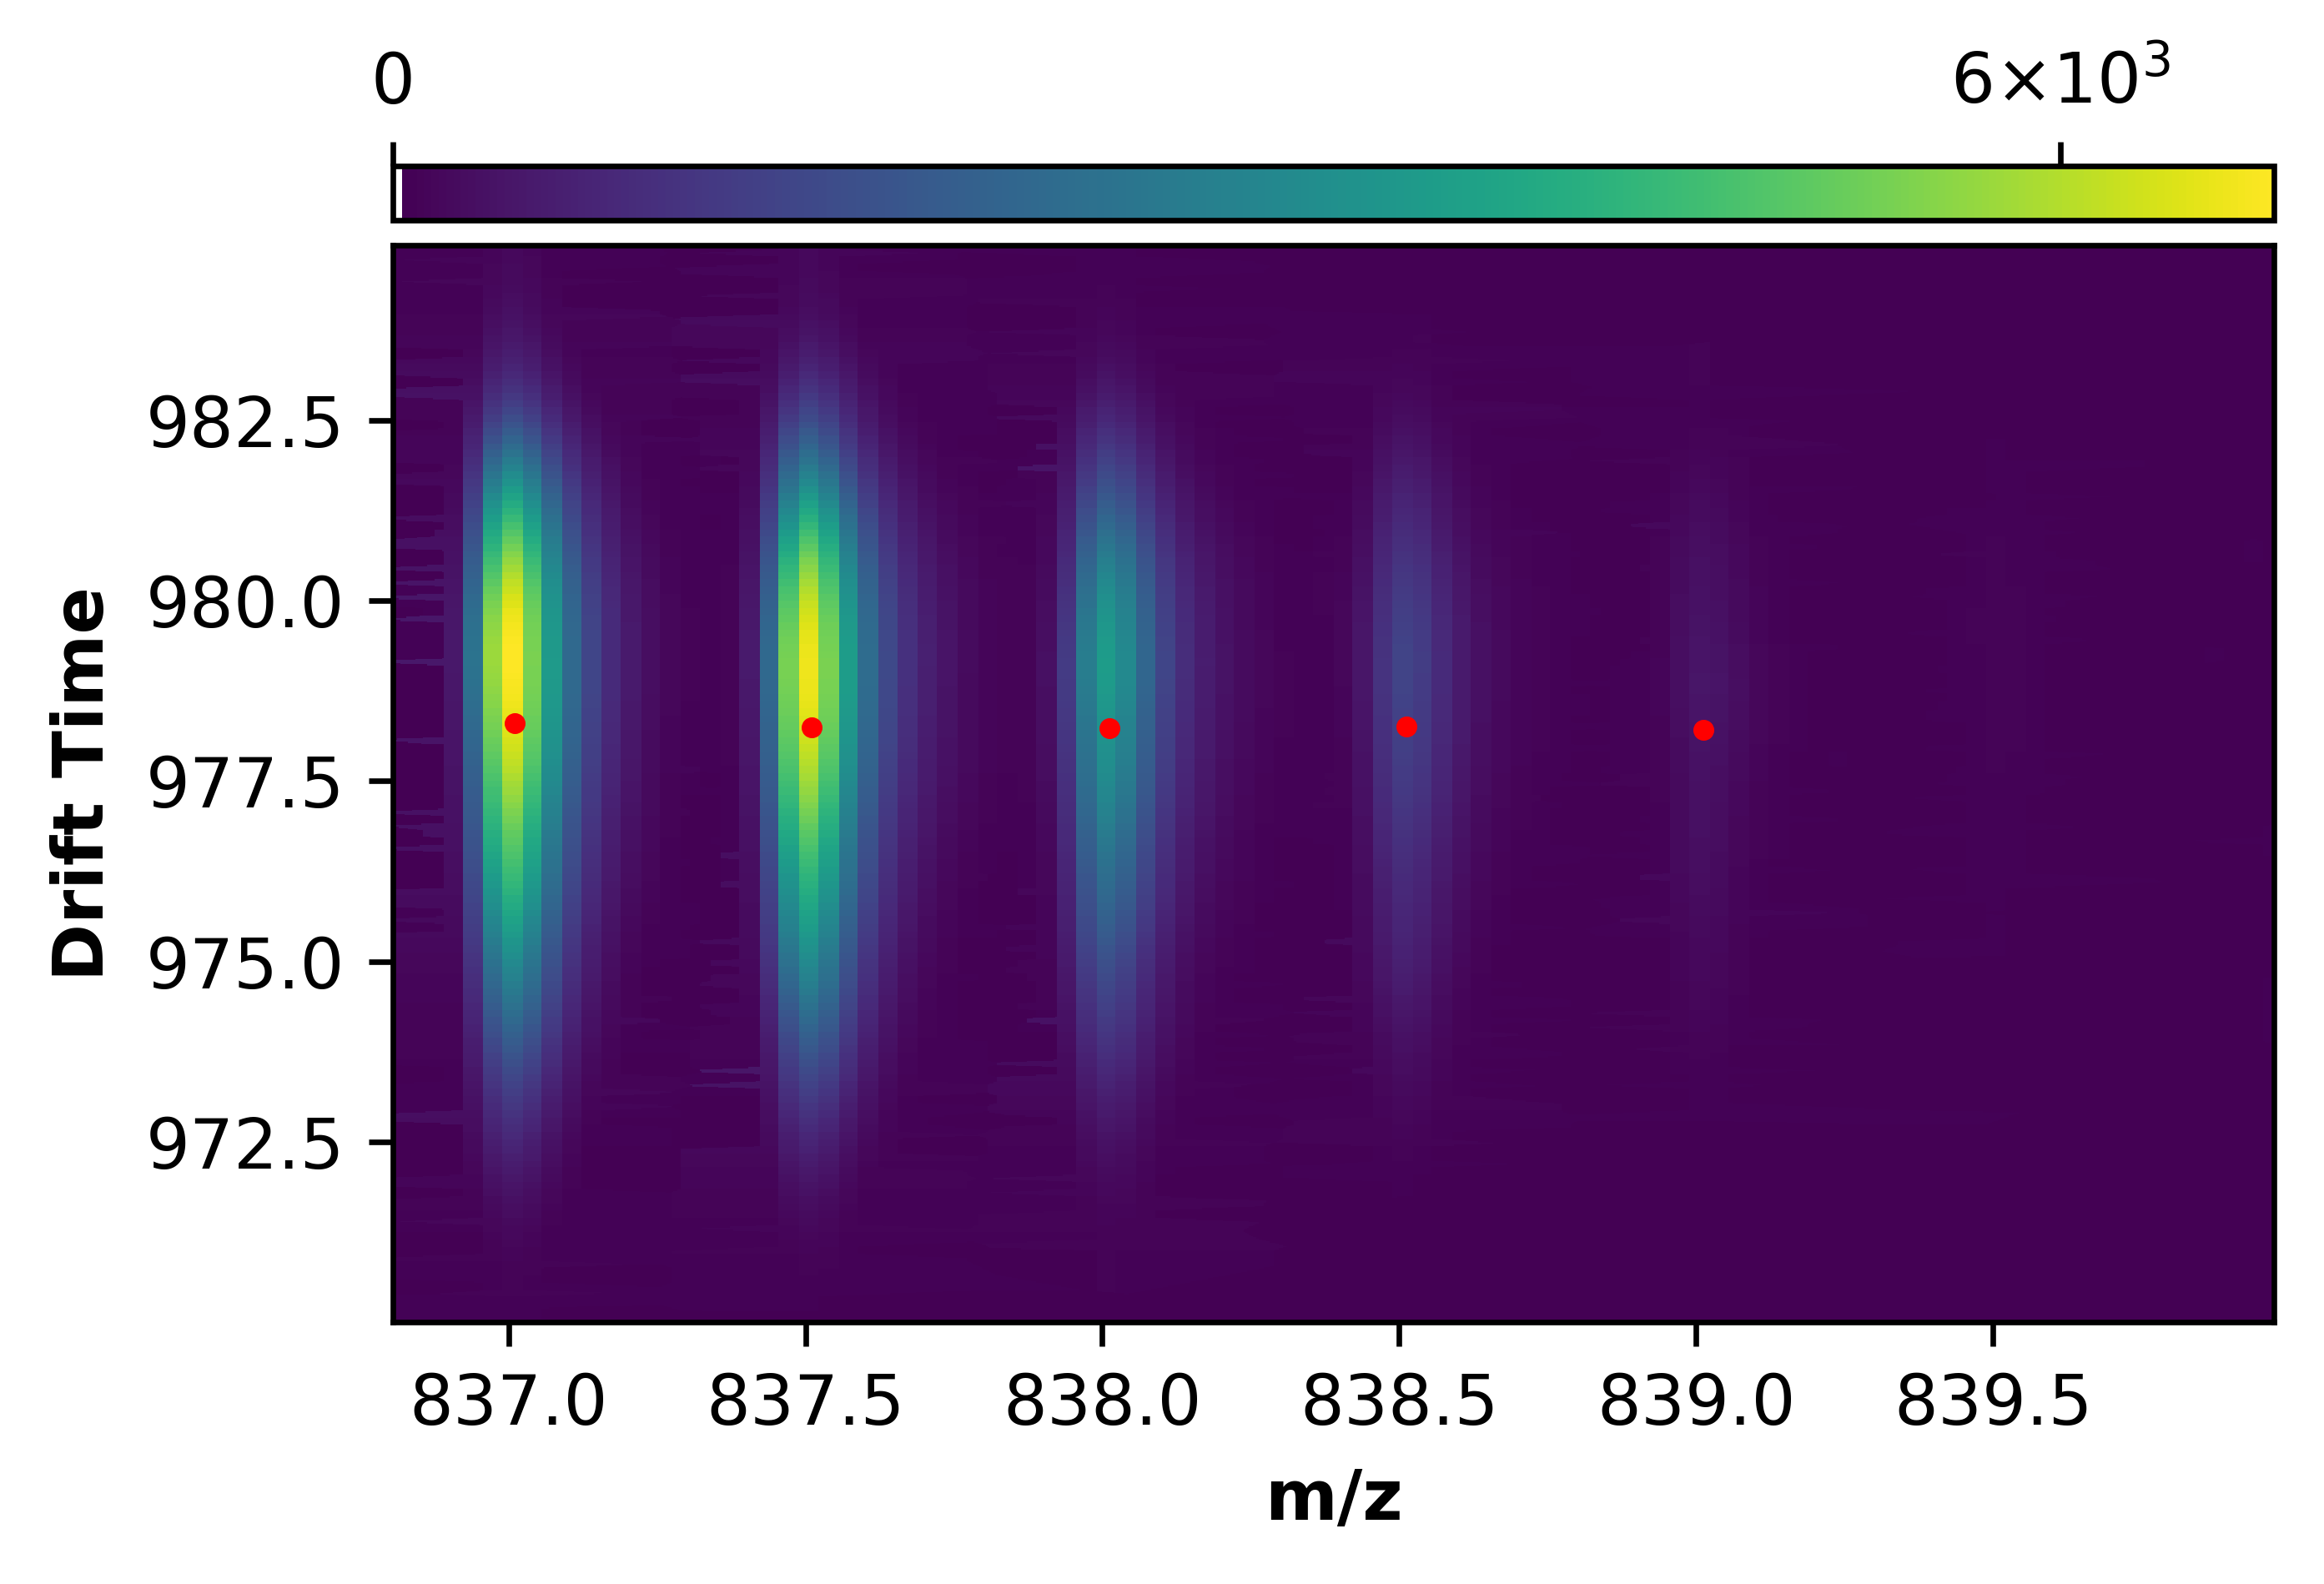

In [20]:
# Plot m/z versus drift
ax = deimos.plot.grid(subset['ms1']['smooth'], cmap='viridis')

# Plot peaks
subset['ms1']['peaks'] = deimos.slice(data['ms1']['peaks'],
                                      by=['drift_time', 'mz'],
                                      low=[970, 836.5],
                                      high=[985, 840])
ax.scatter(subset['ms1']['peaks']['mz_weighted'],
           subset['ms1']['peaks']['drift_time_weighted'],
           s=4, c='r')

plt.show()

### MS2 extraction

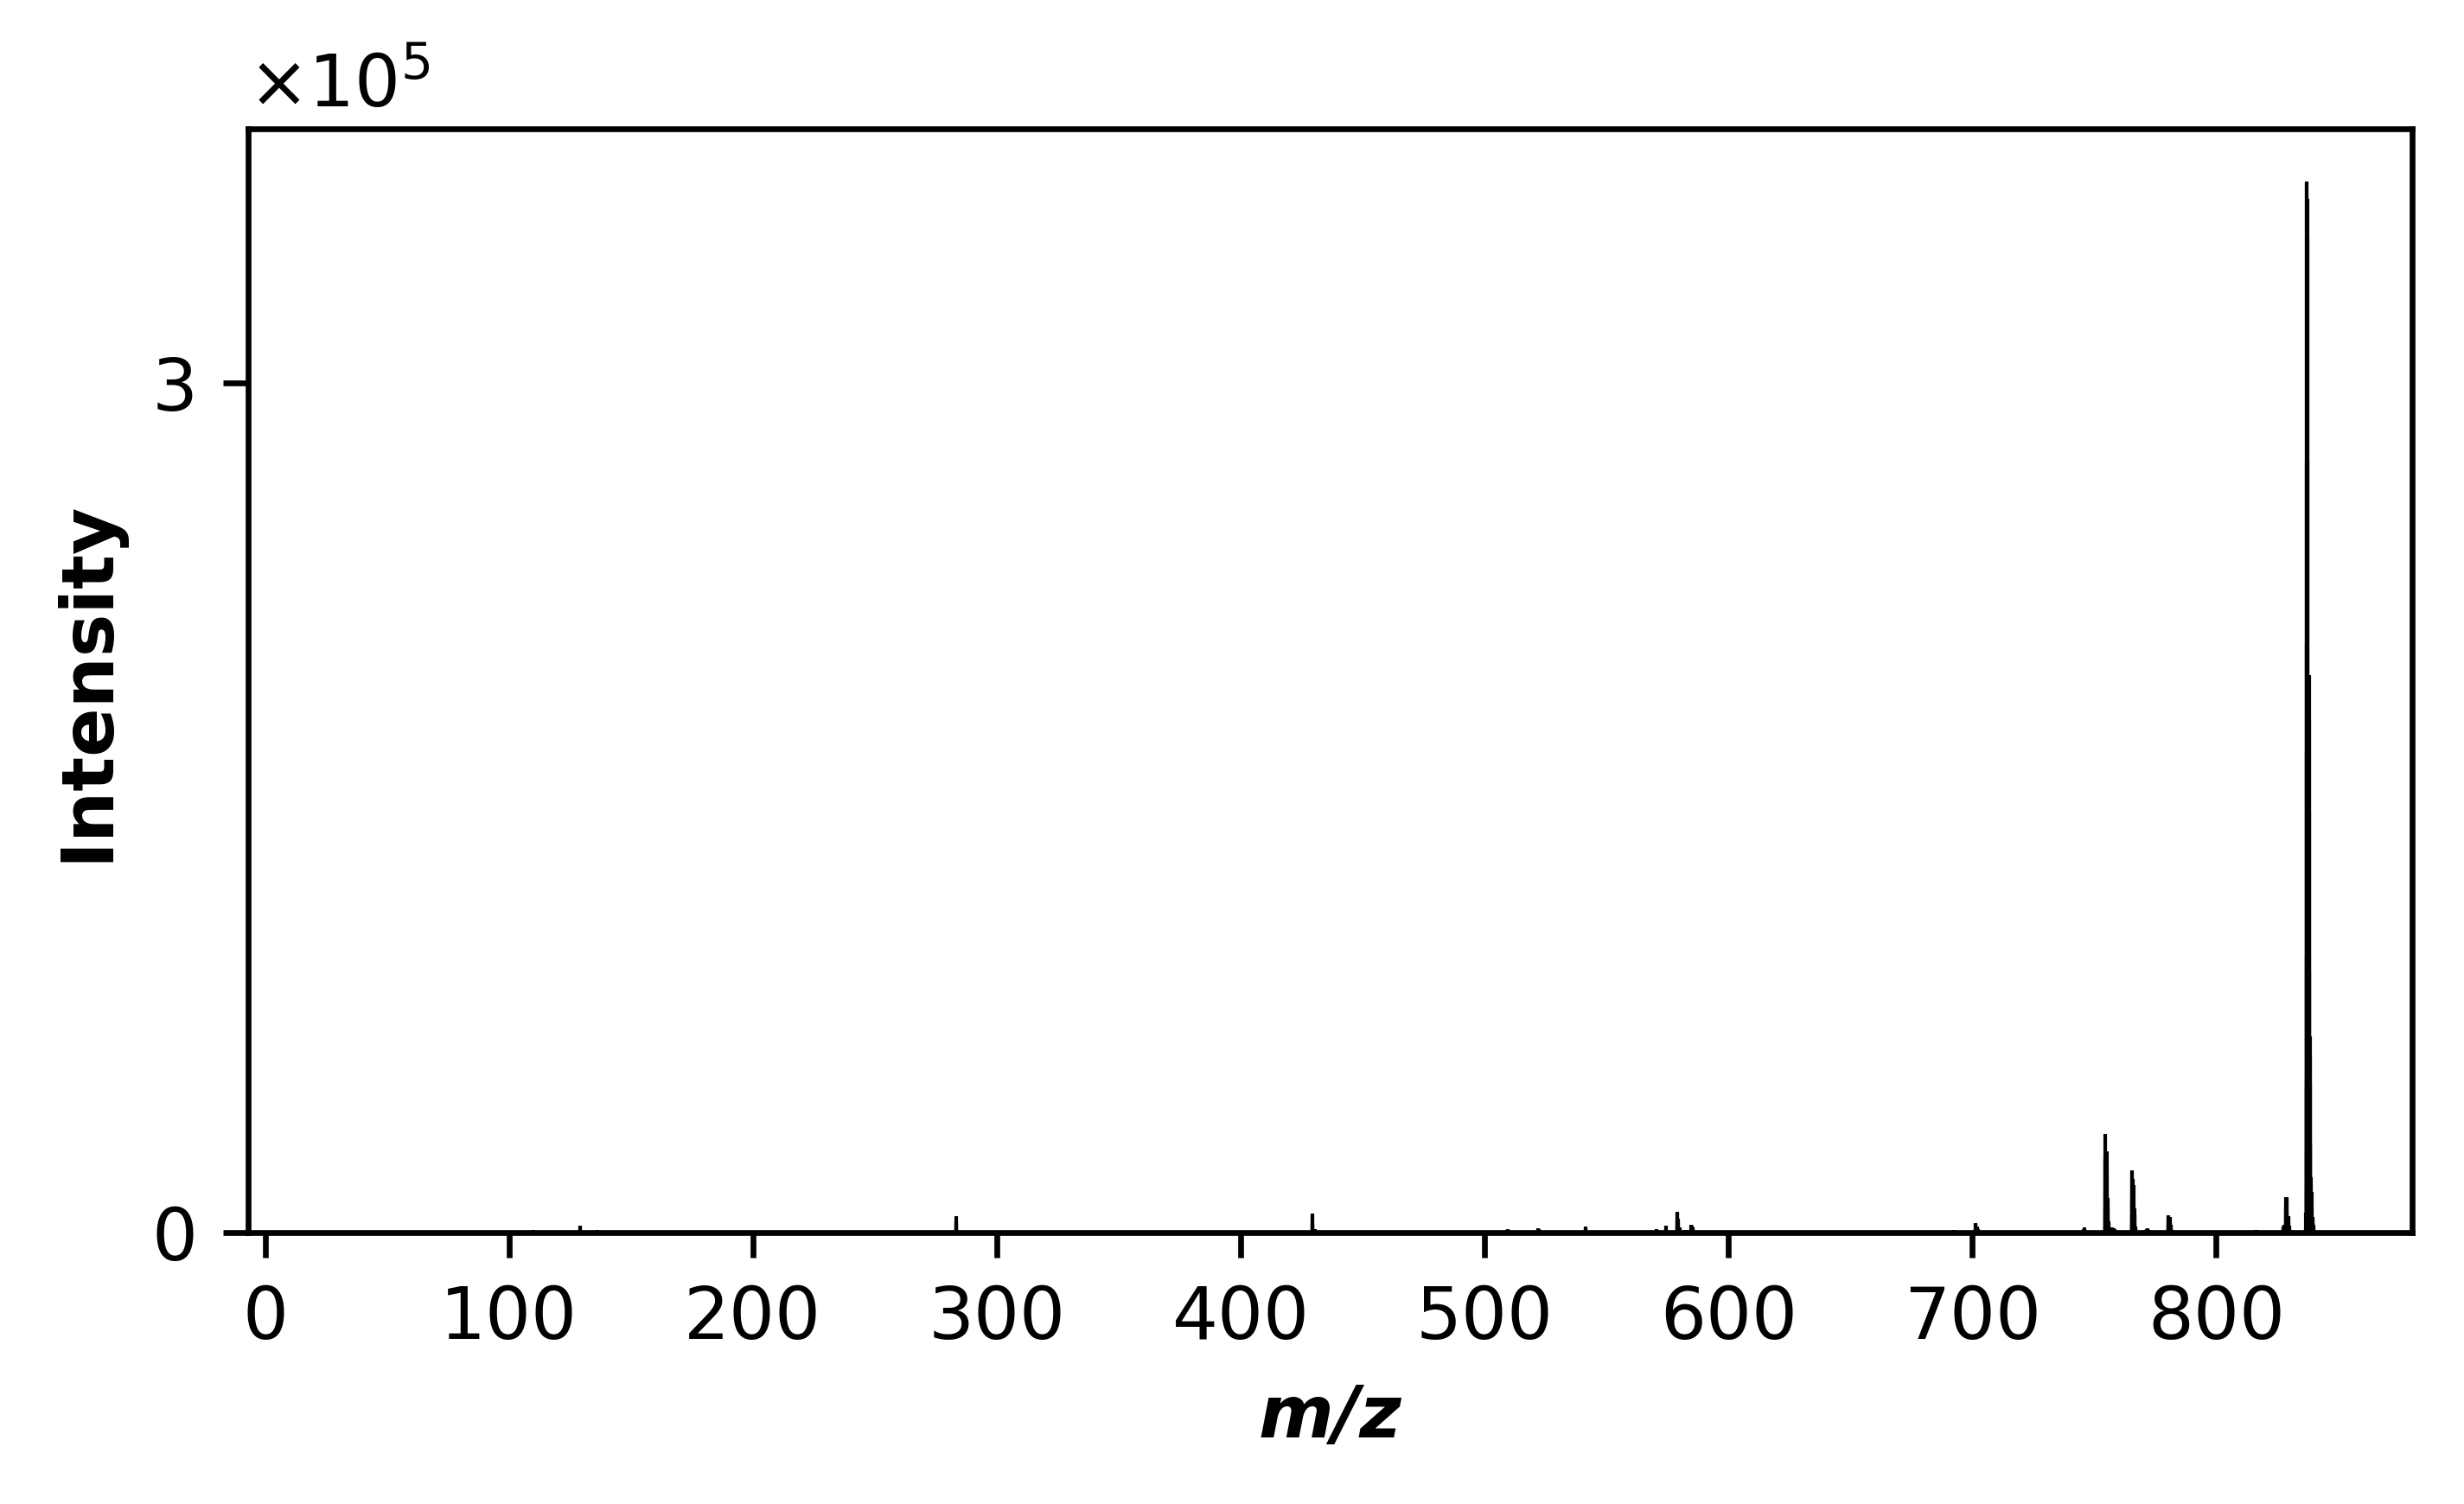

In [21]:
# Corresponding MS2 peaks
subset['ms2']['peaks'] = deimos.slice(data['ms2']['raw'],
                                      by=['drift_time', 'mz'],
                                      low=[970, 0],
                                      high=[985, 840])

# Sum over drift time
subset['ms2']['peaks'] = deimos.collapse(subset['ms2']['peaks'], keep='mz')

# Plot
deimos.plot.stem(subset['ms2']['peaks']['mz'],
                 subset['ms2']['peaks']['intensity'],
                 width=0.5)
plt.tight_layout()
plt.show()

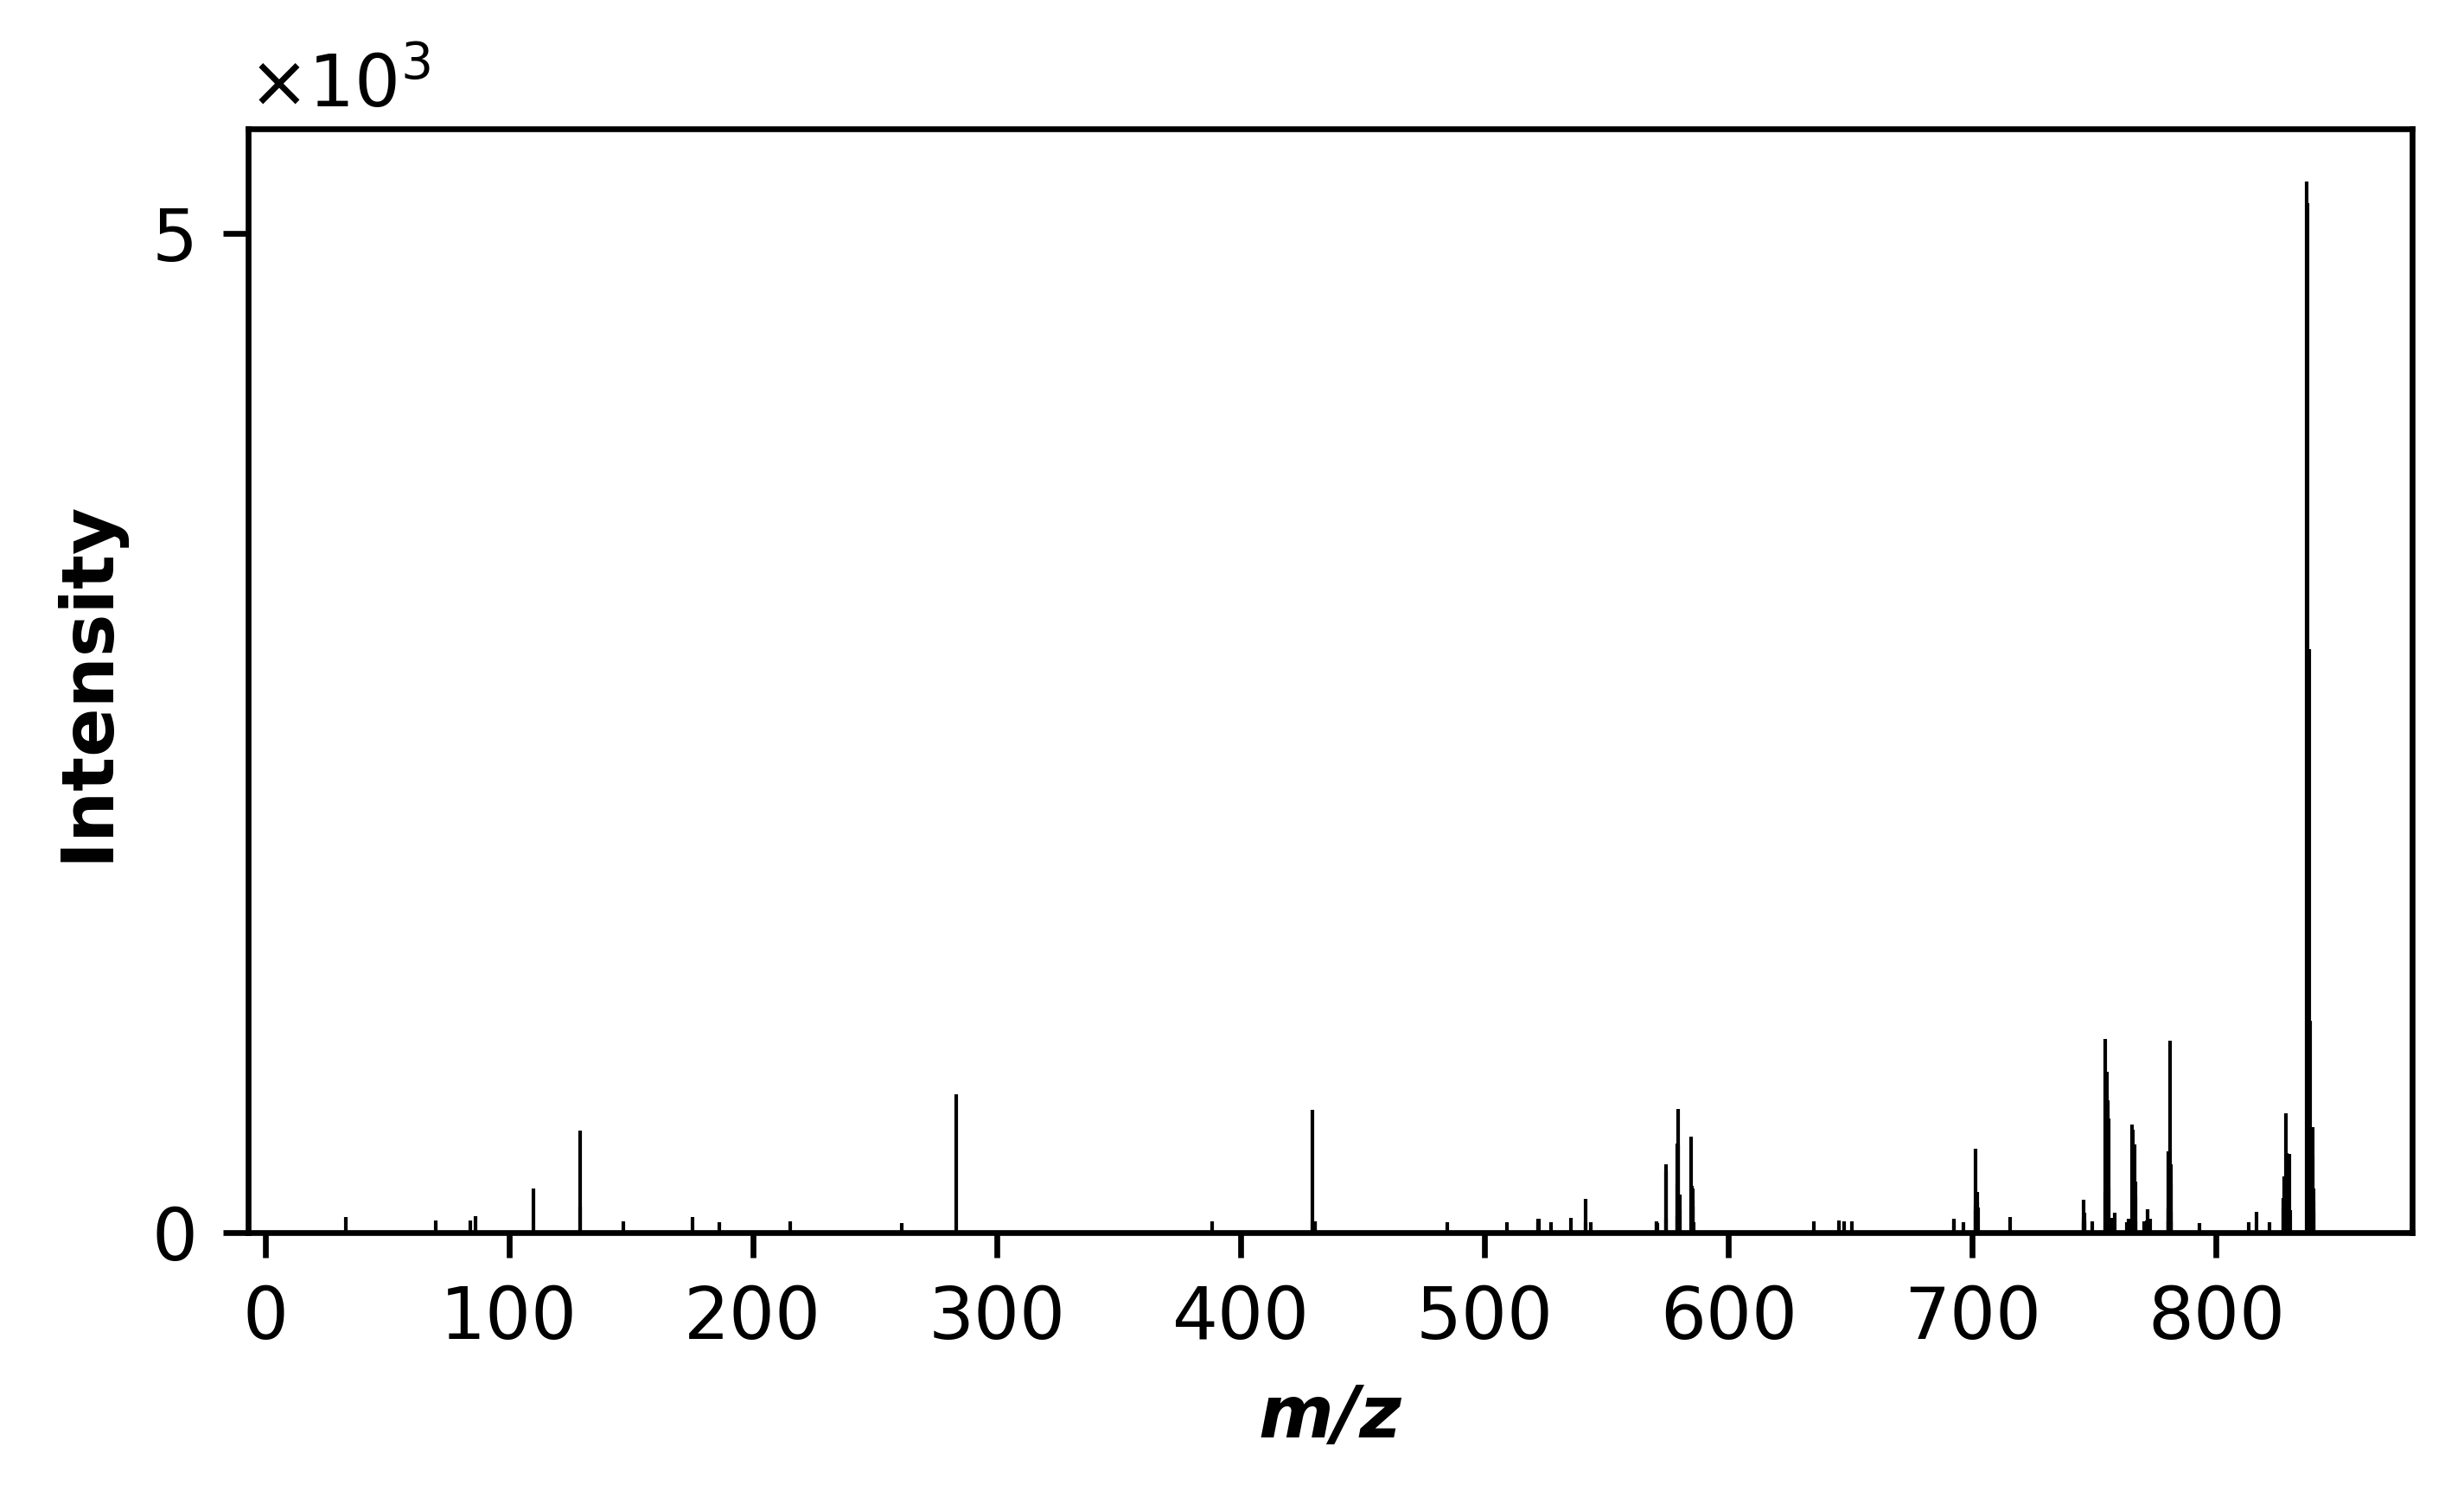

In [22]:
# Corresponding MS2 peaks
subset['ms2']['peaks-2'] = deimos.slice(data['ms2']['peaks'],
                                      by=['drift_time', 'mz'],
                                      low=[970, 0],
                                      high=[985, 840])

# Sum over drift time
subset['ms2']['peaks-2'] = deimos.collapse(subset['ms2']['peaks-2'], keep='mz')

# Plot
deimos.plot.stem(subset['ms2']['peaks-2']['mz'],
                 subset['ms2']['peaks-2']['intensity'],
                 width=0.5)
plt.tight_layout()
plt.show()